In [1]:
from __future__ import division

import os
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from keras.preprocessing import image
from scipy.spatial.distance import cosine

from learning2learn.images import generate_random_shape

Using TensorFlow backend.
/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [66]:
def generate_image(shape, color, texture, target_size=(200, 200)):
    # Generate the base color
    img_color = np.ones(shape=target_size+(3,), dtype=np.float32)*color
    # Generate the base texture
    img_texture = image.load_img(
        '../data/textures/%s' % texture, 
        target_size=target_size, 
        interpolation='bicubic'
    )
    img_texture = image.img_to_array(img_texture) / 255.
    img_texture = img_texture[:,:,0]
    # Put it all together
    img = np.zeros(shape=target_size+(4,), dtype=np.float32)
    img[:,:,:3] = img_color
    img[:,:,3] = img_texture
    # Cutout the shape
    p = mplpath.Path(shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if not p.contains_point((i, j)):
                img[j,i,:] = np.ones_like(img[j,i])
                
    return img

In [6]:
def generate_colors():
    nb_colors = 27
    nb_bins = 3
    vals = np.linspace(0, 0.95, nb_bins)
    colors = np.zeros(shape=(nb_colors,3))
    i = 0
    for r in vals:
        for g in vals:
            for b in vals:
                colors[i] = np.asarray([r, g, b])
                i += 1
    
    return colors

In [17]:
SHAPE_SET = [generate_random_shape(0, 200, 0, 200, 40) for _ in range(50)]
COLOR_SET = generate_colors()
TEXTURE_SET = sorted([file for file in os.listdir('../data/textures') if file.endswith('tiff')])

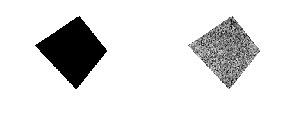

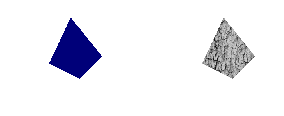

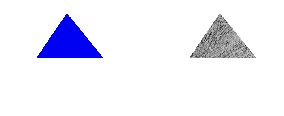

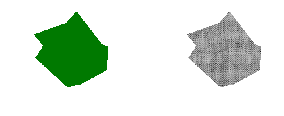

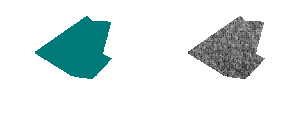

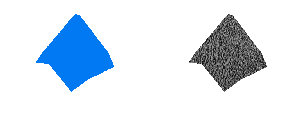

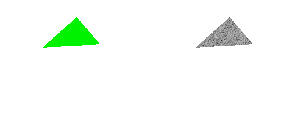

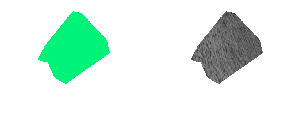

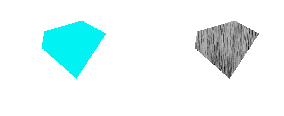

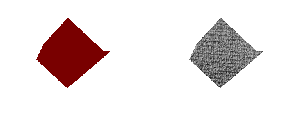

In [67]:
for i in range(10):
    img = generate_image(SHAPE_SET[i], COLOR_SET[i], TEXTURE_SET[i])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 1.5))
    axes[0].imshow(img[:,:,:3])
    axes[0].axis('off')
    axes[1].imshow(img[:,:,3], cmap='gray')
    axes[1].axis('off')
    plt.show()
    print('\n')

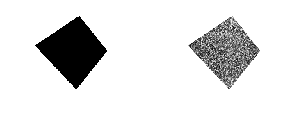

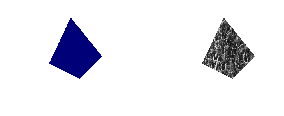

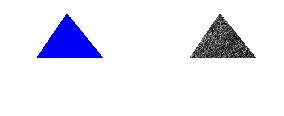

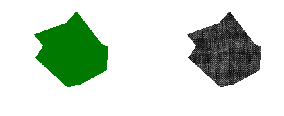

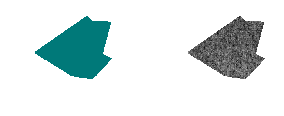

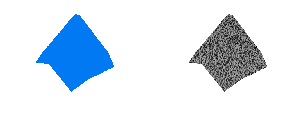

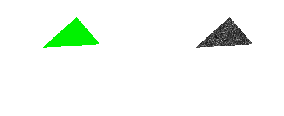

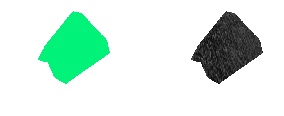

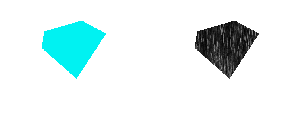

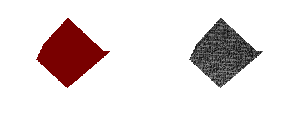

In [50]:
for i in range(10):
    img = generate_image(SHAPE_SET[i], COLOR_SET[i], TEXTURE_SET[i])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 1.5))
    axes[0].imshow(img[:,:,:3])
    axes[0].axis('off')
    axes[1].imshow(img[:,:,3], cmap='gray')
    axes[1].axis('off')
    plt.show()
    print('\n')

In [68]:
ix = [5,7,9,11,13,15,17,19,21,23]
color_set = COLOR_SET[ix]
texture_set = TEXTURE_SET
shape_set = SHAPE_SET

In [69]:
def make_trial(shape_set, color_set, texture_set, target_size=(200, 200)):
    # randomly select 3 of each feature
    s1, s2, s3 = np.random.choice(range(len(shape_set)), 3, replace=False)
    c1, c2, c3 = np.random.choice(range(len(color_set)), 3, replace=False)
    shape1, shape2, shape3 = shape_set[s1], shape_set[s2], shape_set[s3]
    color1, color2, color3 = color_set[c1], color_set[c2], color_set[c3]
    texture1, texture2, texture3 = np.random.choice(texture_set, 3, replace=False)
    # generate the trial images
    baseline = generate_image(shape1, color1, texture1, target_size)
    shape_match = generate_image(shape1, color2, texture2, target_size)
    color_match = generate_image(shape2, color1, texture3, target_size)
    texture_match = generate_image(shape3, color3, texture1, target_size)
    print(texture1, texture2, texture3, texture1)
    
    return [baseline, shape_match, color_match, texture_match]

def build_test_trials(shape_set, color_set, texture_set, nb_trials, target_size=(200, 200)):
    imgs = np.zeros(shape=(4*nb_trials,)+target_size+(4,))
    for i in range(nb_trials):
        imgs[4*i:4*(i+1)] = make_trial(shape_set, color_set, texture_set, target_size)
    
    return imgs

In [70]:
nb_trials = 5
imgs = build_test_trials(shape_set, color_set, texture_set, nb_trials)

1.4.01.tiff 1.3.04.tiff 1.4.02.tiff 1.4.01.tiff
1.3.08.tiff 1.4.02.tiff 1.4.05.tiff 1.3.08.tiff
1.1.12.tiff 1.3.11.tiff 1.1.02.tiff 1.1.12.tiff
1.5.06.tiff 1.5.05.tiff 1.4.01.tiff 1.5.06.tiff
1.4.05.tiff 1.4.01.tiff 1.3.03.tiff 1.4.05.tiff


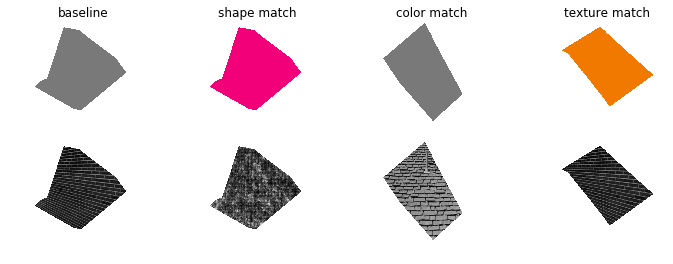

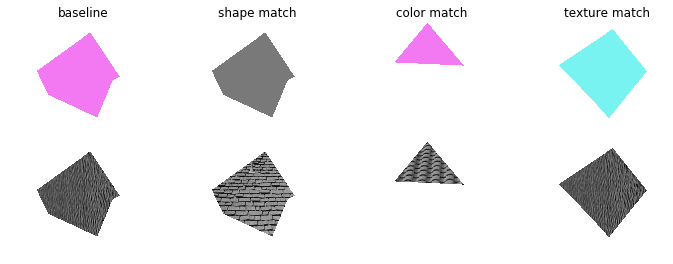

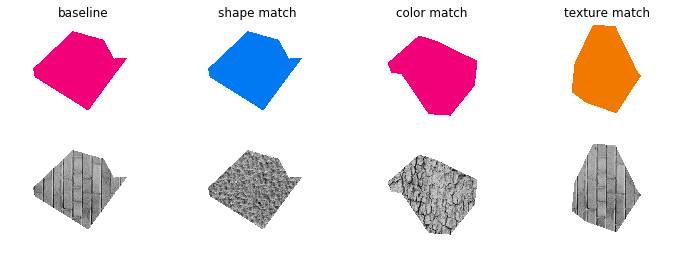

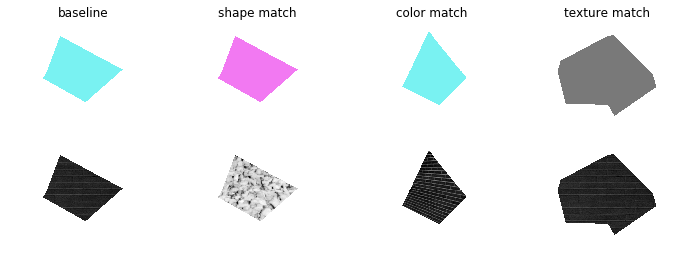

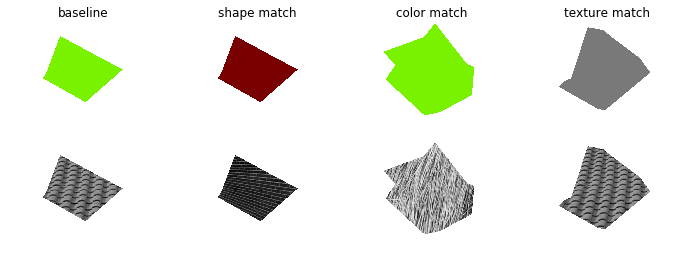

In [71]:
for i in range(nb_trials):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,4))
    # plot colors
    axes[0,0].imshow(imgs[4*i,:,:,:3])
    axes[0,0].axis('off')
    axes[0,0].set_title('baseline')
    axes[0,1].imshow(imgs[4*i+1,:,:,:3])
    axes[0,1].axis('off')
    axes[0,1].set_title('shape match')
    axes[0,2].imshow(imgs[4*i+2,:,:,:3])
    axes[0,2].axis('off')
    axes[0,2].set_title('color match')
    axes[0,3].imshow(imgs[4*i+3,:,:,:3])
    axes[0,3].axis('off')
    axes[0,3].set_title('texture match')
    # plot textures
    axes[1,0].imshow(imgs[4*i,:,:,3], cmap='gray')
    axes[1,0].axis('off')
    #axes[1,0].set_title('baseline')
    axes[1,1].imshow(imgs[4*i+1,:,:,3], cmap='gray')
    axes[1,1].axis('off')
    #axes[1,1].set_title('shape match')
    axes[1,2].imshow(imgs[4*i+2,:,:,3], cmap='gray')
    axes[1,2].axis('off')
    #axes[1,2].set_title('color match')
    axes[1,3].imshow(imgs[4*i+3,:,:,3], cmap='gray')
    axes[1,3].axis('off')
    #axes[1,3].set_title('texture match')
    plt.show()
    print('\n\n')

In [ ]:
# Maybe we should adjust the contrast of the textures so that they're all about equal... let's try

In [57]:
def generate_texture_img(texture):
    img_texture = image.load_img('../data/textures/%s' % texture, target_size=(200, 200), interpolation='bicubic')
    img_texture = image.img_to_array(img_texture) / 255.

    return img_texture

In [58]:
imgs_texture = np.asarray(
    [generate_texture_img(t) for t in TEXTURE_SET]
)

In [82]:
imgs_texture = imgs_texture[:,:,:,-1]

In [ ]:
imgs_texture = np.asarray(
    [generate_texture_img(t) for t in TEXTURE_SET]
)

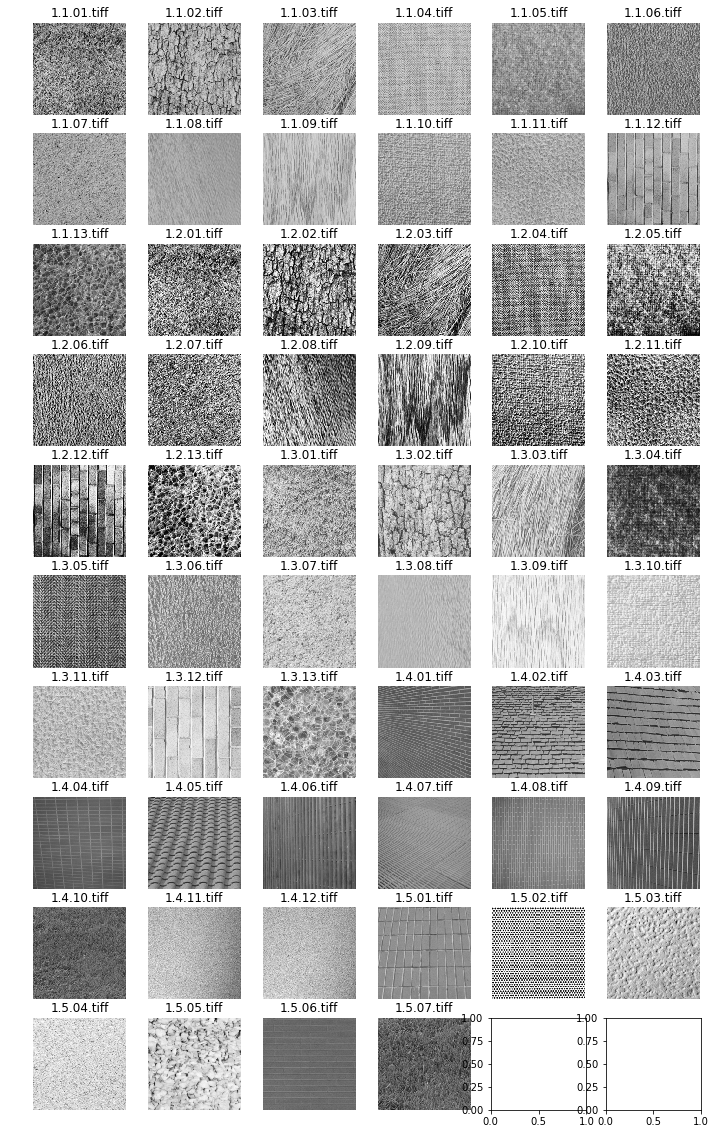

In [80]:
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(12, 20))
for i in range(10):
    for j in range(6):
        ix = i*6+j
        if ix < len(imgs_texture):
            axes[i,j].imshow(imgs_texture[ix,:,:], cmap='gray')
            axes[i,j].axis('off')
            axes[i,j].set_title(TEXTURE_SET[ix])
plt.show()

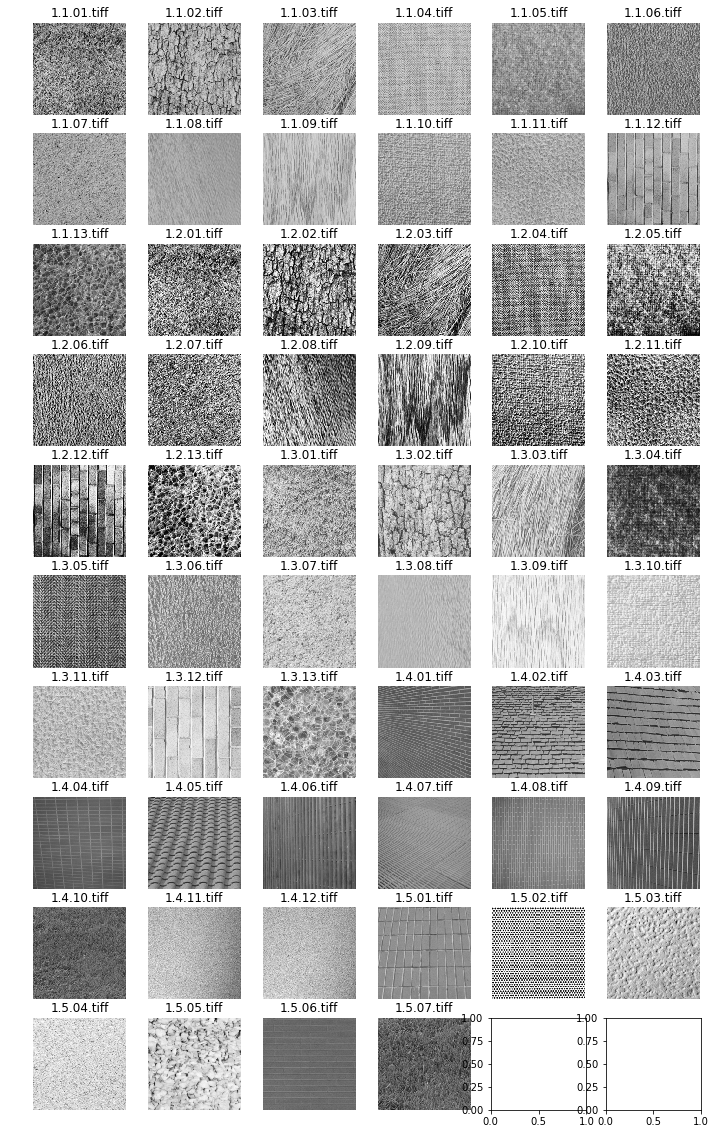

In [81]:
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(12, 20))
for i in range(10):
    for j in range(6):
        ix = i*6+j
        if ix < len(imgs_texture):
            axes[i,j].imshow(imgs_texture[ix])
            axes[i,j].axis('off')
            axes[i,j].set_title(TEXTURE_SET[ix])
plt.show()